# pystencils

In [1]:
import numpy as np
import pystencils as ps
import sympy as sp
from pystencils import create_kernel
from pystencils import plot as plt

In [27]:
sp.init_printing()

In [28]:
input_arr = np.random.rand(1024, 1024)
output_arr = np.zeros_like(input_arr)

In [29]:
def numpy_kernel():
    output_arr[1:-1, 1:-1] = (
        input_arr[2:, 1:-1]
        + input_arr[:-2, 1:-1]
        + input_arr[1:-1, 2:]
        + input_arr[1:-1, :-2]
    )

In [30]:
%%timeit
numpy_kernel()

5.58 ms ± 338 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [31]:
src, dst = ps.fields(src=input_arr, dst=output_arr)

symbolic_description = ps.Assignment(
    dst[0, 0], (src[1, 0] + src[-1, 0] + src[0, 1] + src[0, -1]) / 4
)

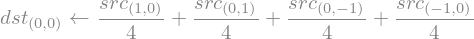

In [32]:
symbolic_description

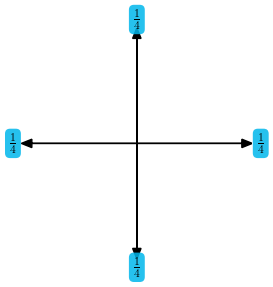

In [33]:
plt.figure(figsize=(3, 3))
ps.stencil.plot_expression(symbolic_description.rhs)

In [34]:
kernel = ps.create_kernel(symbolic_description).compile()

In [35]:
def pystencils_kernel():
    kernel(src=input_arr, dst=output_arr)

In [36]:
%%timeit
pystencils_kernel()

758 µs ± 72.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [37]:
my_field = ps.fields("f(3) : double[2D]")

In [38]:
field_access = my_field[1, 0](1)

In [39]:
field_access

In [40]:
isinstance(field_access, sp.Symbol)

True

In [41]:
img_field = ps.fields("img(4): [2D]")

In [42]:
w1, w2 = sp.symbols("w_1 w_2")
color = 2
sobel_x = (
    -w2 * img_field[-1, 0](color)
    - w1 * img_field[-1, -1](color)
    - w1 * img_field[-1, +1](color)
    + w2 * img_field[+1, 0](color)
    + w1 * img_field[+1, -1](color)
    - w1 * img_field[+1, +1](color)
) ** 2

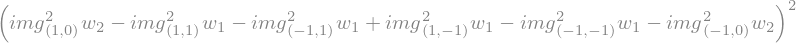

In [43]:
sobel_x

In [44]:
sobel_x = sobel_x.subs(w1, 0.5)

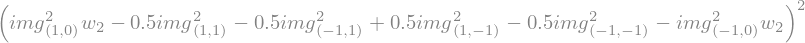

In [45]:
sobel_x

In [46]:
dst_field = ps.fields("dst: [2D]")
update_rule = ps.Assignment(dst_field[0, 0], sobel_x)

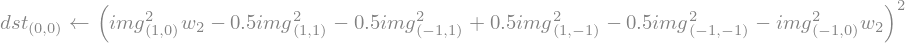

In [47]:
update_rule

In [48]:
ast = create_kernel(update_rule, cpu_openmp=False)
compiled_kernel = ast.compile()

In [49]:
src_arr = np.zeros([20, 30])
dst_arr = np.zeros_like(src_arr)

dst, src = ps.fields(dst=dst_arr, src=src_arr)

In [50]:
grad_x, grad_y = sp.symbols("grad_x, grad_y")

symbolic_description = [
    ps.Assignment(grad_x, (src[1, 0] - src[-1, 0]) / 2),
    ps.Assignment(grad_y, (src[0, 1] - src[0, -1]) / 2),
    ps.Assignment(dst[0, 0], grad_x + grad_y),
]
kernel = ps.create_kernel(symbolic_description)

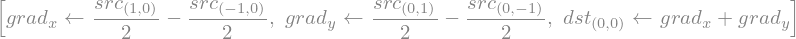

In [51]:
symbolic_description

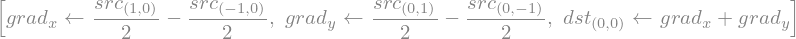

In [52]:
@ps.kernel
def symbolic_description_using_function():
    grad_x @= (src[1, 0] - src[-1, 0]) / 2
    grad_y @= (src[0, 1] - src[0, -1]) / 2
    dst[0, 0] @= grad_x + grad_y


symbolic_description_using_function

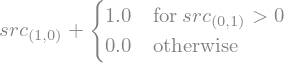

In [53]:
sp.Piecewise((1.0, src[0, 1] > 0), (0.0, True)) + src[1, 0]

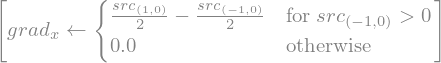

In [54]:
@ps.kernel
def kernel_with_piecewise():
    grad_x @= (src[1, 0] - src[-1, 0]) / 2 if src[-1, 0] > 0 else 0.0


kernel_with_piecewise

In [55]:
@ps.kernel
def somewhat_longer_dummy_kernel(s):
    s.a @= src[0, 1] + src[-1, 0]
    s.b @= 2 * src[1, 0] + src[0, -1]
    s.c @= src[0, 1] + 2 * src[1, 0] + src[-1, 0] + src[0, -1] - src[0, 0]
    dst[0, 0] @= s.a + s.b + s.c


ac = ps.AssignmentCollection(
    main_assignments=somewhat_longer_dummy_kernel[-1:],
    subexpressions=somewhat_longer_dummy_kernel[:-1],
)
ac

"$$a \leftarrow_{} {src}_{(0,1)} + {src}_{(-1,0)}$$"
"$$b \leftarrow_{} 2 {src}_{(1,0)} + {src}_{(0,-1)}$$"
"$$c \leftarrow_{} - {src}_{(0,0)} + 2 {src}_{(1,0)} + {src}_{(0,1)} + {src}_{(0,-1)} + {src}_{(-1,0)}$$"
"$${dst}_{(0,0)} \leftarrow_{} a + b + c$$"


In [56]:
ac.operation_count

{'adds': 8,
 'muls': 2,
 'divs': 0,
 'sqrts': 0,
 'fast_sqrts': 0,
 'fast_inv_sqrts': 0,
 'fast_div': 0}

In [57]:
opt_ac = ps.simp.subexpression_substitution_in_existing_subexpressions(ac)
opt_ac

"$$a \leftarrow_{} {src}_{(0,1)} + {src}_{(-1,0)}$$"
"$$b \leftarrow_{} 2 {src}_{(1,0)} + {src}_{(0,-1)}$$"
"$$c \leftarrow_{} - {src}_{(0,0)} + a + b$$"
"$${dst}_{(0,0)} \leftarrow_{} a + b + c$$"


In [58]:
opt_ac.operation_count

{'adds': 6,
 'muls': 1,
 'divs': 0,
 'sqrts': 0,
 'fast_sqrts': 0,
 'fast_inv_sqrts': 0,
 'fast_div': 0}

In [59]:
kernel = ps.create_kernel(ps.Assignment(dst[0, 0], src[2, 0] + src[-1, 0]))
ps.show_code(kernel)

FUNC_PREFIX void kernel(double * RESTRICT  _data_dst, double * RESTRICT const _data_src)
{
   for (int64_t ctr_0 = 2; ctr_0 < 18; ctr_0 += 1)
   {
      for (int64_t ctr_1 = 2; ctr_1 < 28; ctr_1 += 1)
      {
         _data_dst[30*ctr_0 + ctr_1] = _data_src[30*ctr_0 + ctr_1 + 60] + _data_src[30*ctr_0 + ctr_1 - 30];
      }
   }
}

In [60]:
gl_spec = [
    (0, 2),  # 0 ghost layers at the left, 2 at the right border
    (1, 0),
]  # 1 ghost layer at the lower y, one at the upper y coordinate
kernel = ps.create_kernel(
    ps.Assignment(dst[0, 0], src[2, 0] + src[-1, 0]), ghost_layers=gl_spec
)
ps.show_code(kernel)

FUNC_PREFIX void kernel(double * RESTRICT  _data_dst, double * RESTRICT const _data_src)
{
   for (int64_t ctr_0 = 0; ctr_0 < 18; ctr_0 += 1)
   {
      for (int64_t ctr_1 = 1; ctr_1 < 30; ctr_1 += 1)
      {
         _data_dst[30*ctr_0 + ctr_1] = _data_src[30*ctr_0 + ctr_1 + 60] + _data_src[30*ctr_0 + ctr_1 - 30];
      }
   }
}

In [61]:
invalid_description = [
    ps.Assignment(dst[1, 0], src[1, 0] + src[-1, 0]),
    ps.Assignment(dst[0, 0], src[1, 0] - src[-1, 0]),
]
try:
    invalid_kernel = ps.create_kernel(invalid_description)
    assert False, "Should never be executed"
except ValueError as e:
    print(e)

Field dst is written at two different locations


In [63]:
valid_kernel = ps.create_kernel(ps.Assignment(src[0, 0], 2 * src[0, 0] + 42))

In [64]:
v = ps.fields("v(2): double[2D]")
valid_kernel = ps.create_kernel(
    [
        ps.Assignment(v[0, 0](1), 2 * v[0, 0](1) + 42),
        ps.Assignment(v[0, 1](0), 2 * v[1, 0](0) + 42),
    ]
)

In [65]:
@ps.kernel
def not_allowed():
    a, b = sp.symbols("a b")
    a @= src[0, 0]
    b @= a + 3
    a @= src[-1, 0]
    dst[0, 0] @= a + b


try:
    ps.create_kernel(not_allowed)
    assert False
except ValueError as e:
    print(e)

Assignments not in SSA form, multiple assignments to a


In [66]:
@ps.kernel
def not_allowed():
    dst[0, 0] @= src[0, 1] + src[1, 0]
    dst[0, 0] @= 2 * dst[0, 0]


try:
    ps.create_kernel(not_allowed)
    assert False
except ValueError as e:
    print(e)

Field dst is written twice at the same location


In [67]:
tmp_var = sp.Symbol("a")


@ps.kernel
def allowed():
    tmp_var @= src[0, 1] + src[1, 0]
    dst[0, 0] @= 2 * tmp_var


ast = ps.create_kernel(allowed)
ps.show_code(ast)

FUNC_PREFIX void kernel(double * RESTRICT  _data_dst, double * RESTRICT const _data_src)
{
   for (int64_t ctr_0 = 1; ctr_0 < 19; ctr_0 += 1)
   {
      for (int64_t ctr_1 = 1; ctr_1 < 29; ctr_1 += 1)
      {
         const double a = _data_src[30*ctr_0 + ctr_1 + 1] + _data_src[30*ctr_0 + ctr_1 + 30];
         _data_dst[30*ctr_0 + ctr_1] = a*2.0;
      }
   }
}